In [74]:
import cv2
import numpy as np
import whisper
import os
import tempfile
from moviepy import VideoFileClip
from collections import Counter
import re
import time
import random
from collections import Counter
import easyocr
from IPython.display import Video
from paddleocr import PaddleOCR
import matplotlib.pyplot as plt

os.environ["PATH"] = "/work/users/s/m/smerrill/ffmpeg-7.0.2-amd64-static:" + os.environ["PATH"]

In [76]:
class ZoomSpeakerDiarization:
    def __init__(self, video_path):
        self.video_path = video_path
        self.capture = cv2.VideoCapture(video_path)
        if not self.capture.isOpened():
            raise ValueError(f"Could not open video file: {video_path}")
        self.fps = self.capture.get(cv2.CAP_PROP_FPS)
        self.total_frames = int(self.capture.get(cv2.CAP_PROP_FRAME_COUNT))
        self.speaker_changes = []
        
        #self.reader = easyocr.Reader(['en'], gpu=True)
        self.reader = ocr = PaddleOCR(
                    use_angle_cls=True,
                    lang='en')
        self.whisper_model = whisper.load_model("large-v2")
        self.sr = cv2.dnn_superres.DnnSuperResImpl_create()
        self.sr.readModel('/work/users/s/m/smerrill/models/EDSR_Tensorflow/models/EDSR_x4.pb')
        self.sr.setModel("edsr", 4)


    def ocr_name_from_box(self, box_img, debug=True, paragraph=True):
        """
        Uses EasyOCR to extract text from a cropped participant name box.
        Returns the best detected text string.
        """
        
        # Super-resolution model
        upscaled = self.sr.upsample(box_img)

        # OCR
        text=''
        ocr_results = self.reader.ocr(upscaled, cls=True)
        print(ocr_results)
        # Extract and print detected text
        for line in ocr_results[0]:
            text = line[1][0]       # Detected text
            confidence = line[1][1] # Confidence score
            #print(f"{text} (conf: {confidence:.2f})")
        
        #results = self.reader.readtext(box_img, detail=0, paragraph=paragraph)  # detail=0 returns just text[2][3]
        # Combine results into one string
        #if isinstance(results, list):
        #    text = ' '.join(results).strip()
        #else:
        #    text = str(results).strip()

        if debug:
            print("OCR Output:", repr(text))
            plt.figure(figsize=(6,2))
            plt.imshow(upscaled)
            plt.title(f"Upscaled and OCR: {text}")
            plt.axis('off')
            plt.show()

        return text if text else "No Speaker"

    def crop_black_border(self, frame, threshold=10):
        """
        Crops black borders from an image (NumPy array).
        Args:
            frame: np.ndarray, input image (BGR or RGB)
            threshold: int, pixel values <= threshold are considered black
        Returns:
            Cropped image as np.ndarray
        """
        if len(frame.shape) == 3:
            # For color images
            mask = np.any(frame > threshold, axis=2)
        else:
            # For grayscale images
            mask = frame > threshold

        coords = np.argwhere(mask)
        if coords.size == 0:
            raise ValueError("No non-black content found in frame.")

        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1  # slices are exclusive at the top

        return frame[y0:y1, x0:x1]

    def find_speaker(self, frame, overlay=True, debug=True):
        """
        Attempts to find the active speaker region in a Zoom screenshot.
        Handles:
          - Green/yellow border (participant grid)
          - Fixed overlay in upper right (screen share mode)
          - Yellow pop-up (Zoom's speaker label)
        Returns:
          frame_with_box, (x, y, w, h) of detected box, cropped box image
        """
        frame = self.crop_black_border(frame)
        frame_disp = frame.copy()
        h, w = frame.shape[:2]
        detected_box = None
        cutout = None

        # 1. Try to find green/yellow border (participant grid)
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        lower_green = np.array([20, 40, 60])
        upper_green = np.array([80, 255, 255])
        mask_green = cv2.inRange(hsv, lower_green, upper_green)
        contours, _ = cv2.findContours(mask_green, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        max_rect = None
        max_area = 0
        for contour in contours:
            approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
            if len(approx) == 4:
                x, y, ww, hh = cv2.boundingRect(approx)
                area = ww * hh
                if area > max_area and ww > 40 and hh > 40:
                    max_rect = (x, y, ww, hh)
                    max_area = area
        if max_rect:
            detected_box = max_rect
            if overlay:
                cv2.rectangle(frame_disp, (detected_box[0], detected_box[1]),
                              (detected_box[0] + detected_box[2], detected_box[1] + detected_box[3]),
                              (0, 255, 0), 3)
            cutout = frame[detected_box[1]:detected_box[1]+detected_box[3], detected_box[0]:detected_box[0]+detected_box[2]]
            if debug:
                print("Detected green/yellow border (participant grid).")
        else:
            # Fallback: Fixed overlay in upper right (screen share mode)
            # Use proportions to handle resizing
            overlay_w = int(w * 0.18)  # ~26% of width (tune as needed)
            overlay_h = int(h * 0.18)  # ~20% of height (tune as needed)
            x1 = w - overlay_w
            y1 = 0
            detected_box = (x1, y1, overlay_w, overlay_h)
            cutout = frame[y1:y1+overlay_h, x1:x1+overlay_w]
            if overlay:
                cv2.rectangle(frame_disp, (x1, y1), (x1+overlay_w, y1+overlay_h), (255, 0, 0), 3)
            if debug:
                print("Detected fixed overlay (upper right).")

        if debug:
            plt.figure(figsize=(10, 6))
            plt.imshow(cv2.cvtColor(frame_disp, cv2.COLOR_BGR2RGB))
            plt.title("Detected Speaker Box")
            plt.axis('off')
            plt.show()
            if cutout is not None:
                plt.figure(figsize=(3, 2))
                plt.imshow(cv2.cvtColor(cutout, cv2.COLOR_BGR2RGB))
                plt.title("Speaker Crop")
                plt.axis('off')
                plt.show()

        return frame_disp, detected_box, cutout
    

    def determine_active_speaker(self, frame):
        result_frame, speaker_box, cutout = self.find_speaker(frame, overlay=True, debug=False)
        name = self.ocr_name_from_box(self.crop_name_only(cutout), debug=False)
        return name

    
    def extract_audio(self):
        """Extract audio from video for transcription"""
        temp_audio = tempfile.NamedTemporaryFile(suffix='.wav', delete=False).name
        video_clip = VideoFileClip(self.video_path)
        video_clip.audio.write_audiofile(temp_audio)
        video_clip.close()
        return temp_audio
    
    def transcribe_audio(self, audio_path):
        """Transcribe audio using Whisper"""
        print("Transcribing audio...")
        result = self.whisper_model.transcribe(audio_path)
        
        return result
    
    def process_video(self, sampling_rate=1):
        """Process the video to create speaker diarization"""
        print(f"Processing video: {self.video_path}")
        print(f"Total frames: {self.total_frames}, FPS: {self.fps}")
        
        # Extract and transcribe audio
        audio_path = self.extract_audio()
        transcript_data = self.transcribe_audio(audio_path)
        
        # Process video frames at the specified sampling rate
        frame_interval = int(self.fps / sampling_rate)
        current_frame = 0
        last_speaker = None
        
        while current_frame < self.total_frames:
            self.capture.set(cv2.CAP_PROP_POS_FRAMES, current_frame)
            ret, frame = self.capture.read()
            
            if not ret:
                break
                
            timestamp = current_frame / self.fps
            active_speaker = self.determine_active_speaker(frame)
            
            # Record speaker change
            if active_speaker != last_speaker:
                self.speaker_changes.append((timestamp, active_speaker))
                last_speaker = active_speaker
            
            # Output progress
            if current_frame % (frame_interval * 10) == 0:
                progress = (current_frame / self.total_frames) * 100
                print(f"Progress: {progress:.1f}% - Current speaker: {active_speaker}")
            
            current_frame += frame_interval
        
        # Clean up
        self.capture.release()
        os.unlink(audio_path)
        
        # Map speaker changes to transcript segments
        return self.map_speakers_to_transcript(transcript_data)
    
    def map_speakers_to_transcript(self, transcript_data):
        """Map detected speakers to transcript segments"""
        segments = transcript_data["segments"]
        diarized_transcript = []
        
        for segment in segments:
            start_time = segment["start"]
            end_time = segment["end"]
            text = segment["text"]
            
            # Find the speaker active at the start of this segment
            speaker = "Unknown"
            for timestamp, spk in reversed(self.speaker_changes):
                if timestamp <= start_time:
                    speaker = spk
                    break
            
            diarized_transcript.append({
                "speaker": speaker,
                "start": start_time,
                "end": end_time,
                "text": text
            })
        
        return diarized_transcript
    
    
    def crop_name_only(self, box_img, height_ratio=0.22, width_ratio=0.5, bottom_padding=2):
        h, w = box_img.shape[:2]
        name_h = int(h * height_ratio)
        name_w = int(w * width_ratio)
        # Remove bottom padding to avoid colored lines
        name_region = box_img[h - name_h:h - bottom_padding, 0:name_w]
        return name_region
    
    def clean_crop_above_border(self, img, border_px=5):
        """Crop a few pixels above the bottom to remove colored border."""
        h, w = img.shape[:2]
        return img[:h-border_px, :]
    
    
    def save_transcript(self, diarized_transcript, output_file):
        """Save the diarized transcript to a file"""
        with open(output_file, 'w', encoding='utf-8') as f:
            for segment in diarized_transcript:
                start_time = self.format_timestamp(segment["start"])
                end_time = self.format_timestamp(segment["end"])
                f.write(f"[{start_time} --> {end_time}] {segment['speaker']}: {segment['text']}\n")
        
        print(f"Transcript saved to {output_file}")
    
    def format_timestamp(self, seconds):
        """Format seconds into HH:MM:SS"""
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        seconds = int(seconds % 60)
        return f"{hours:02d}:{minutes:02d}:{seconds:02d}"
    

In [77]:
video_path = '_0SkrWBu3Sg_1min.mp4'
sampling_rate = 1

diarizer = ZoomSpeakerDiarization(video_path)
#diarized_transcript = diarizer.process_video(sampling_rate=sampling_rate)

[2025/05/20 17:21:01] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/nas/longleaf/home/smerrill/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/nas/longleaf/home/smerrill/.paddleocr/whl/rec/en/en_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_te

100%|█████████████████████████████████████| 2.87G/2.87G [00:44<00:00, 69.1MiB/s]


In [23]:
#Video(video_path, embed=True, width=640, height=360)

In [24]:
#diarizer.save_transcript(diarized_transcript, 'test.txt')


### Debug
Select random frames from video to test

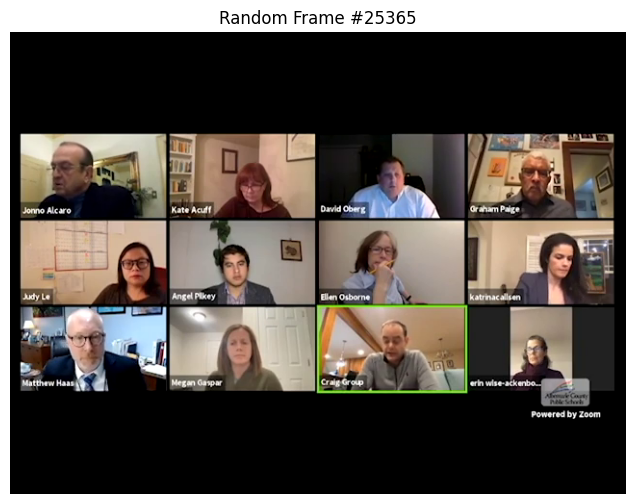

Detected green/yellow border (participant grid).


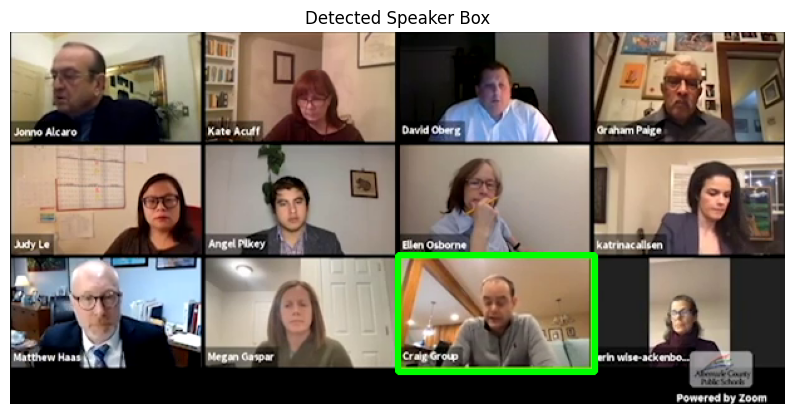

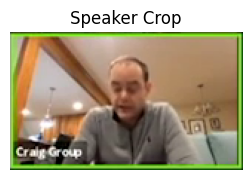

[2025/05/20 17:22:43] ppocr DEBUG: dt_boxes num : 1, elapse : 0.020670175552368164
[2025/05/20 17:22:43] ppocr DEBUG: cls num  : 1, elapse : 0.007808685302734375
[2025/05/20 17:22:43] ppocr DEBUG: rec_res num  : 1, elapse : 0.08336806297302246
[[[[[15.0, 11.0], [194.0, 16.0], [193.0, 55.0], [14.0, 50.0]], ('Craig Group', 0.9889487624168396)]]]
OCR Output: 'Craig Group'


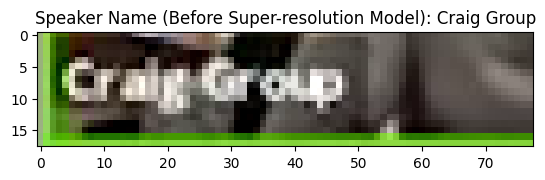

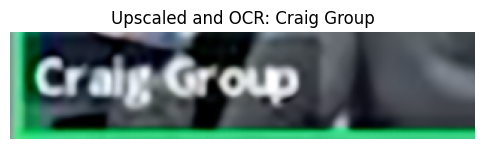

<Figure size 640x480 with 0 Axes>

In [78]:
video_path = '/work/users/s/m/smerrill/Albemarle'
video_id = "MgHvV_9dxdA.mp4"
video_path = os.path.join(video_path, video_id)

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise ValueError("Could not open video file.")

# Get total number of frames
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Pick a random frame index
rand_idx = random.randint(0, total_frames - 1)

cap.set(cv2.CAP_PROP_POS_FRAMES, rand_idx)


# Read the random frame
ret, frame = cap.read()
cap.release()
if not ret:
    raise ValueError("Could not read frame.")

plt.figure(figsize=(10,6))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title(f"Random Frame #{rand_idx}")
plt.axis('off')
plt.show()

# Run your speaker detection and OCR pipeline
result_frame, speaker_box, cutout = diarizer.find_speaker(frame, overlay=True)


if cutout is not None:
    name_crop = diarizer.crop_name_only(cutout)
    
    plt.imshow(cv2.cvtColor(name_crop, cv2.COLOR_BGR2RGB))
    plt.title(f"Speaker Name (Before Super-resolution Model): {name}")

    name = diarizer.ocr_name_from_box(name_crop)
else:
    plt.text(0.5, 0.5, "No speaker box detected", ha='center', va='center', fontsize=16)
    plt.axis('off')

plt.tight_layout()
plt.show()
